In [96]:
import pandas as pd
import numpy as np
import os
import requests
import json
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as dtc 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.tree import plot_tree 
from sklearn import metrics
from sklearn import tree
import scipy.stats as st
import statsmodels.formula.api as sm
%matplotlib inline

In [2]:
df = pd.read_csv("20210302_clean_geocoded.csv")

Dropping the observations with no geocode information exists. 

In [3]:
df = df[df['lat'] != 0]

Getting CEU's lattitude and longtitude so that we can compare listings according to their distance to CEU.

In [4]:
nominatim1 = "https://nominatim.openstreetmap.org/search/"
nominatim2= "?format=json"

CEU = requests.get(nominatim1 + "Central European University, Budapest" + nominatim2)
lat_original = json.loads(CEU.text)[0]['lat']
lon_original = json.loads(CEU.text)[0]['lon']
print(lat_original, lon_original)

47.500918150000004 19.05015577954415


Now I have to define a distance function like we did before.

In [5]:
from math import sin, cos, sqrt, atan2, radians
def distance(row):
    R = 6373
    lat1 = radians(row['lat'])
    lon1 = radians(row['lon'])
    lat2 = radians(float(lat_original))
    lon2 = radians(float(lon_original))
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R*c

df['dist'] = df.apply(lambda x:distance(x), axis = 1)

In [6]:
del df['Raw Address']
del df['Address_y']

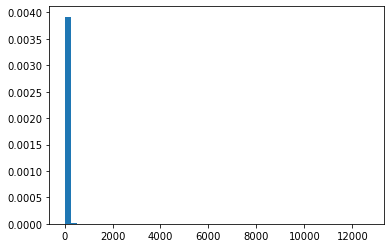

In [20]:
temp1 = plt.hist(df['dist'], density=True, bins=50, label="Data")

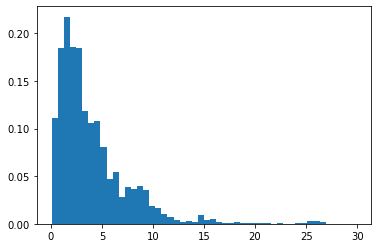

In [26]:
temp2 = plt.hist(df[df['dist'] < 30]['dist'], density = True, bins = 50)

There seems to be some extreme values in our distance column. It seems that some of the addresses we have provided returned with completely non-relevant geolocations. I will drop listings that are 30km and more further away from CEU.

In [27]:
df = df[df['dist'] < 30]

In [29]:
df.to_csv("20210302_final.csv", index = False)

We have more than 12.000 observations. We can start now with some visualizations and exploratory analysis.

<AxesSubplot:title={'center':"Mean rent price per Budapest's districts"}, xlabel='kerület'>

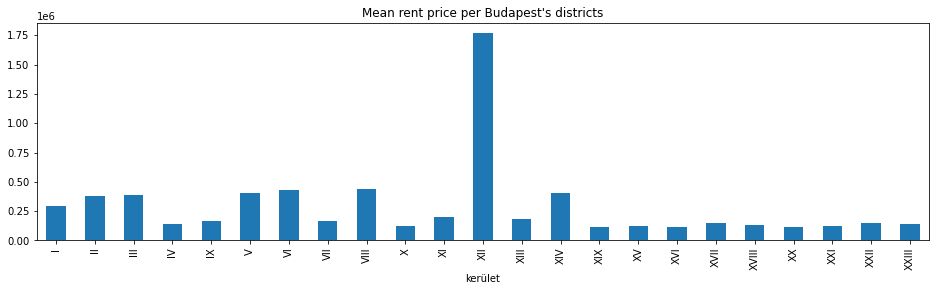

In [30]:
kerület = df.groupby('kerület')['Price'].mean()
kerület.plot(kind = 'bar', title = "Mean rent price per Budapest's districts", figsize = (16,4))

I will dig deeper for 12th district in particular but google images shows nice and large houses to start with. The mean rent is not reasonable and there might be an extreme value issue though.

We can continue building on the above graph.

<AxesSubplot:title={'center':"Mean rent price per Budapest's districts grouped by pet allowance"}, xlabel='kerület'>

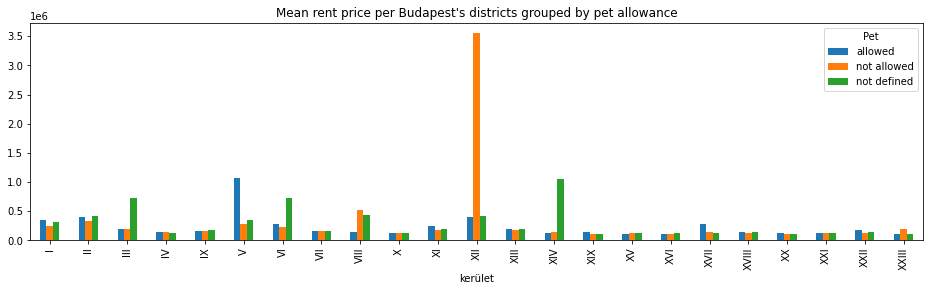

In [31]:
pet_kerület = df.groupby(['kerület', 'Pet'])['Price'].mean().reset_index()
pet_kerület = pet_kerület.pivot(index='kerület', columns='Pet', values='Price')
pet_kerület.plot(kind = 'bar', title = "Mean rent price per Budapest's districts grouped by pet allowance", figsize = (16,4))

There is definitely an outlier for 12th district. The pricing for pet allowance shouldn't differ this much.

In [34]:
df.sort_values('Price', ascending = False).head()

,ID,Address_x,Size,Price,Rooms,Floor,Quality,Inner Height,Heating,Furnished,...,Pet,Year Built,Floors,Lift,Orientation,View,kerület,lat,lon,dist
4573,31680842,"Kútvölgy, XII. kerület",75,716800000.0,3,1,new,less than 3m,gáz (cirko),partly furnished,...,not allowed,2020,3,no,south west,panoramic,XII,47.509419,18.990725,4.564573
14987,32078841,"Szugló utca 125, XIV. kerület",65,230000000.0,3,5,newly built,less than 3m,házközponti egyedi méréssel,not furnished,...,not defined,not defined,5,yes,not defined,street,XIV,47.523119,19.123135,6.013250
11795,32029720,"Révay köz, VI. kerület",60,230000000.0,2,5,new,not defined,házközponti,not furnished,...,not defined,before 1950,5,yes,not defined,panoramic,VI,47.501035,19.055044,0.367559
14812,32076820,"Corvin sétány 8, VIII. kerület",46,200000000.0,2,5,newly built,less than 3m,házközponti egyedi méréssel,furnished,...,not allowed,2020,10,yes,not defined,courtyard,VIII,47.486034,19.077684,2.649733
6150,31810900,"Belváros, V. kerület",110,129825319.0,3,3,renovated,more than 3m,gáz (cirko),not defined,...,allowed,before 1950,5,yes,south,courtyard,V,47.491918,19.054694,1.057604


Well, there is definitely something wrong with this prices. No house can have a rent of 716mm forints. At least I hope not. The listing can be seen by visiting https://ingatlan.com/31680842. Definitely a nice house but probably have a couple of extra zeroes in the rent value nevertheless.

In [37]:
df[df['Price'] > 5000000].sort_values('Price', ascending = False)

,ID,Address_x,Size,Price,Rooms,Floor,Quality,Inner Height,Heating,Furnished,...,Pet,Year Built,Floors,Lift,Orientation,View,kerület,lat,lon,dist
4573,31680842,"Kútvölgy, XII. kerület",75,716800000.0,3,1,new,less than 3m,gáz (cirko),partly furnished,...,not allowed,2020,3,no,south west,panoramic,XII,47.509419,18.990725,4.564573
11795,32029720,"Révay köz, VI. kerület",60,230000000.0,2,5,new,not defined,házközponti,not furnished,...,not defined,before 1950,5,yes,not defined,panoramic,VI,47.501035,19.055044,0.367559
14987,32078841,"Szugló utca 125, XIV. kerület",65,230000000.0,3,5,newly built,less than 3m,házközponti egyedi méréssel,not furnished,...,not defined,not defined,5,yes,not defined,street,XIV,47.523119,19.123135,6.013250
14812,32076820,"Corvin sétány 8, VIII. kerület",46,200000000.0,2,5,newly built,less than 3m,házközponti egyedi méréssel,furnished,...,not allowed,2020,10,yes,not defined,courtyard,VIII,47.486034,19.077684,2.649733
6150,31810900,"Belváros, V. kerület",110,129825319.0,3,3,renovated,more than 3m,gáz (cirko),not defined,...,allowed,before 1950,5,yes,south,courtyard,V,47.491918,19.054694,1.057604
12586,32044997,"Szigony utca, VIII. kerület",38,110000000.0,1,0,in good condition,not defined,gáz (cirko),not defined,...,not defined,before 1950,4,not defined,not defined,not defined,VIII,47.482699,19.079226,2.979998
12844,32049629,"Zemplén Győző utca, III. kerület",56,100000000.0,3,not defined,not defined,not defined,nincs megadva,not defined,...,not defined,not defined,not defined,not defined,not defined,not defined,III,47.595901,19.044188,10.574389


I am going to draw a line at HUF 5 million and drop the listings above that price. Every observation that has a price higher than 5 million also has a price more than 10 million. These must be a data quality issue for sure.  

In [38]:
df = df[df['Price'] < 5000000]

<AxesSubplot:title={'center':"Mean rent price per Budapest's districts grouped by pet allowance"}, xlabel='kerület'>

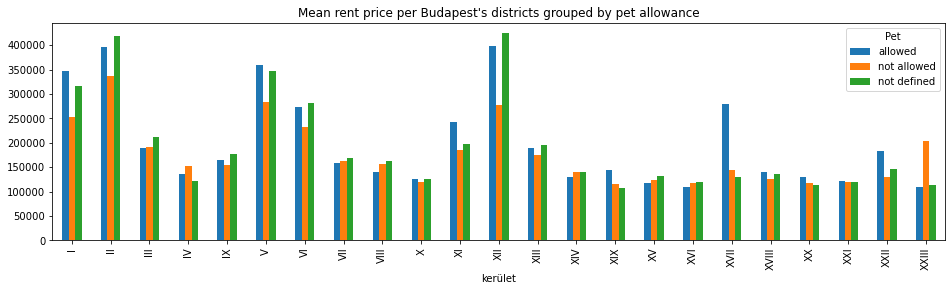

In [39]:
pet_kerület = df.groupby(['kerület', 'Pet'])['Price'].mean().reset_index()
pet_kerület = pet_kerület.pivot(index='kerület', columns='Pet', values='Price')
pet_kerület.plot(kind = 'bar', title = "Mean rent price per Budapest's districts grouped by pet allowance", figsize = (16,4))

This looks much better. The maximum mean rent is around 400.000 and 1st, 2nd and 5th district are on a similar level with 12th district now.

Lets try to see how size and number of rooms looks like.

<AxesSubplot:title={'center':'Mean rent price per number of rooms'}, xlabel='Rooms'>

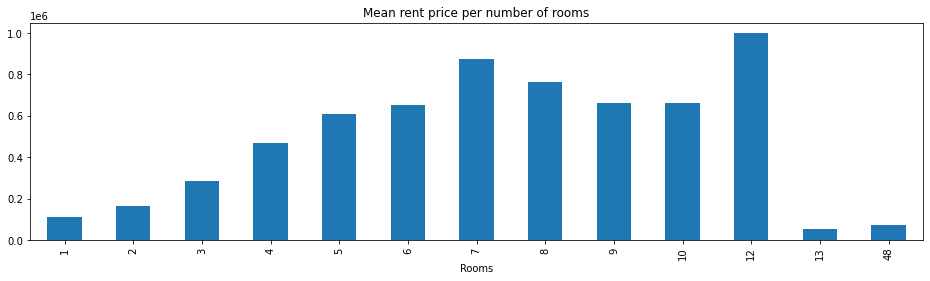

In [40]:
rooms = df.groupby('Rooms')['Price'].mean()
rooms.plot(kind = 'bar', title = "Mean rent price per number of rooms", figsize = (16,4))

Okay, this also looks rather wrong. We are not interested in renting a 48 room apartment. The pricing doesn't make sense as well. Maybe we can draw a line at 7 rooms. (There are 17 listings with room size more than 6). There seems to be genuine listings with 7 rooms so I wanted to include them even though they are way out of my league.

In [41]:
df = df[df['Rooms'] < 8]

In [101]:
df.to_csv("20210302_final.csv", index = False)

<AxesSubplot:title={'center':'Mean rent price per number of rooms'}, xlabel='Rooms'>

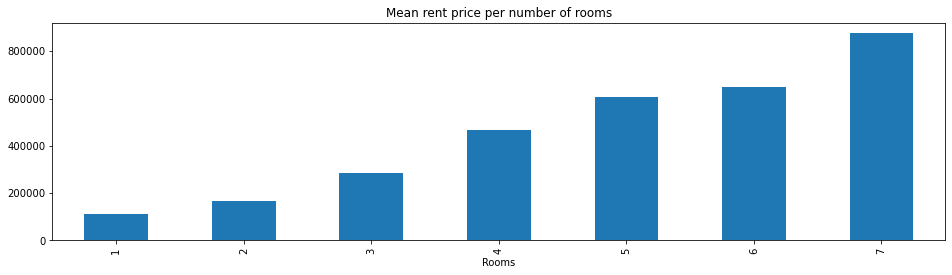

In [42]:
rooms = df.groupby('Rooms')['Price'].mean()
rooms.plot(kind = 'bar', title = "Mean rent price per number of rooms", figsize = (16,4))

This is a better, and it is also less surprising. 

<AxesSubplot:xlabel='Size'>

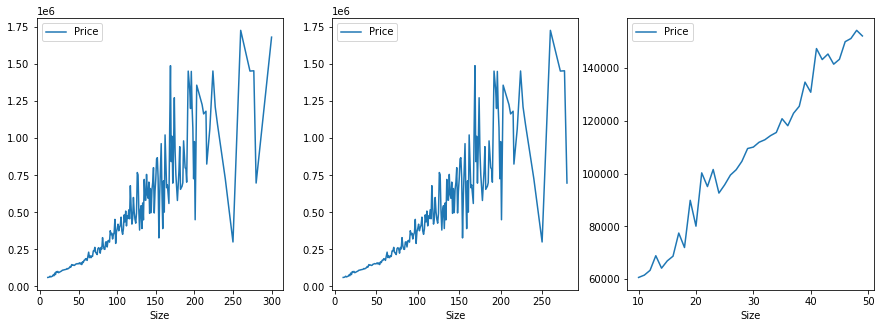

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3)
sizes_full = df.groupby('Size')['Price'].mean().reset_index()
sizes = df[df['Size']<300].groupby('Size')['Price'].mean().reset_index()
sizes_narrow = df[df['Size']<50].groupby('Size')['Price'].mean().reset_index()

sizes_full.plot(x = 'Size', y = 'Price', ax = axes[0], figsize = (15, 5))
sizes.plot(x = 'Size', y = 'Price', ax = axes[1] , figsize = (15, 5))
sizes_narrow.plot(x = 'Size', y = 'Price', ax = axes[2] , figsize = (15, 5))


Room sizes bigger than 300m2 and lower than 10m2 seems unreasonable. There doesn't seem to be many houses in these regions anyways.

In [44]:
df = df[(df['Size'] >= 10) & (df['Size'] <= 300)] 

Okay, now we can start with our analysis. I am planning to fit a simple OLS which is
easily interpretable to see the effects of our features to rent prices in Budapest. But first lets see some more graphs.

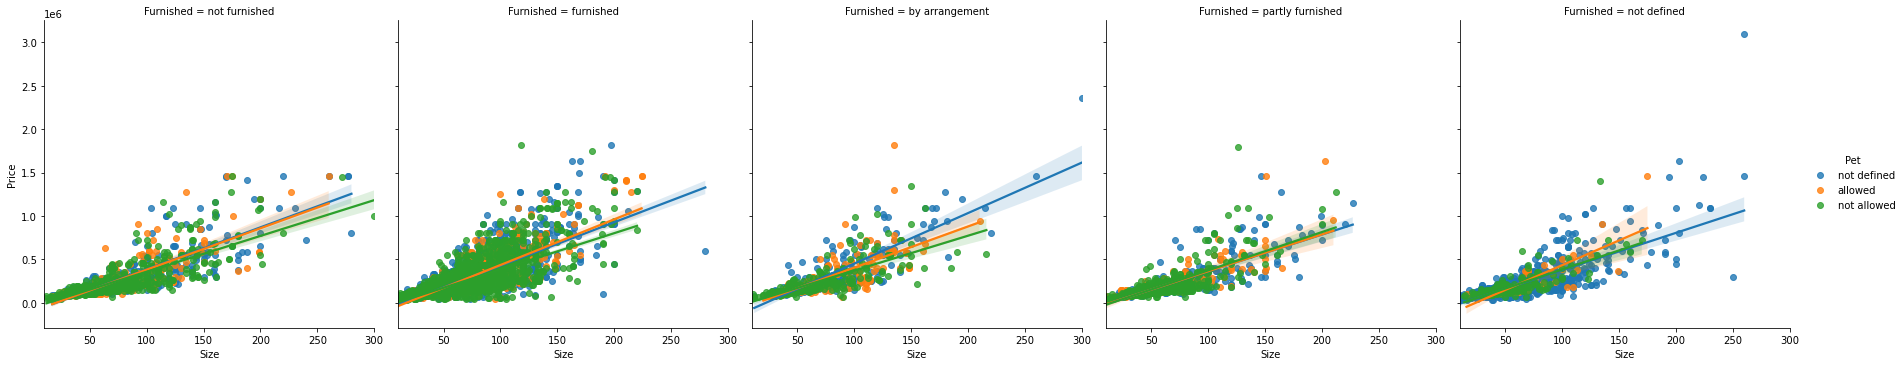

In [45]:
import seaborn as sns
sns.lmplot(data=df, x='Size',y='Price', hue='Pet', col='Furnished')

So it seems pet allowance doesn't have a meaningfull premium in furnished listings. This is good to know. However, most of the listings doesn't allow pets and this is rather bad news for me.

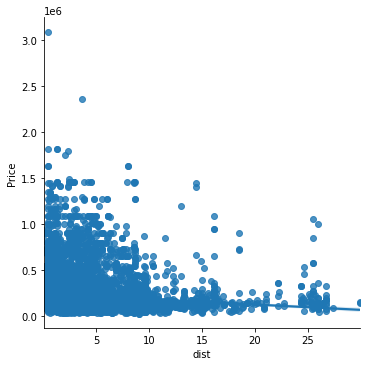

In [47]:
sns.lmplot(data=df, x='dist',y='Price')

It seems that distance from CEU is not a very significant determinant of rents in Budapest. There is a very slight negative association though.

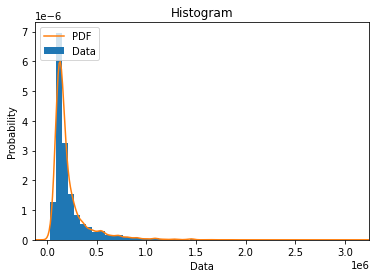

In [48]:
plt.hist(df['Price'], density=True, bins=50, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(df['Price'])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("Histogram");

Our prices seems to resemble a lognormal distribution. A log transformation to our price variable might make our analysis easier.

In [74]:
df['LogPrice'] = np.log(df['Price'])

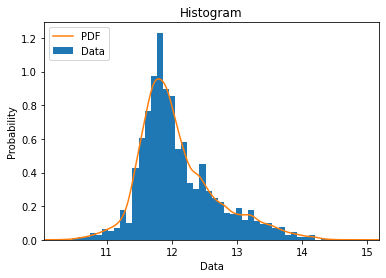

In [75]:
plt.hist(df['LogPrice'], density=True, bins=50, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(df['Log(Price)'])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("Histogram");

Much better.

In [79]:
df = df.rename(columns={'Inner Height': 'Inner_Height', 'Year Built': 'Year_Built'})

In [84]:
X = df[['Size', 'Rooms', 'Floor', 'Quality', 'Inner_Height', 'Furnished', 'Year_Built', 'Floors', 'Lift', 'Orientation', 'View', 'kerület', 'dist']].values
y = df[['LogPrice']]

In [82]:
OLS = sm.ols(formula= 
    "LogPrice ~ Size + Rooms + Floor + Quality + Inner_Height + Furnished + Year_Built + Floors + Lift + Orientation + View + kerület + dist", 
    data=df).fit()

print(OLS.summary())  

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     527.0
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:49:36   Log-Likelihood:                -1515.1
No. Observations:               12597   AIC:                             3216.
Df Residuals:                   12504   BIC:                             3908.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

The results are promising. We have a 0.79 adjusted Rsquared which is not very bad. We can directly see that Size and Rooms are among the important variables. 

As an example, since our model is a log-lin model, we can interpret the Size's coeffiecent of 0.0112 as 1 m2 increase in house size increases the rent price by 1.12 percent. Similarly, an additional room seem to increase the rent by almost 7 percent and 8th Kerület (where I live) is 27 percent cheaper than 1st Kerület. The presence of a lift causes a 5 percent increase in rent and taller the building lower the rent. 

Distance from CEU on the other hand, is statistically significant to explain rent differences but it doesn't make much sense in terms of rents and real world measures. For instance, every kilometer away from CEU causes the rent to decline by 0.3 percent. This is not significant at all. 

There are a lot of information we can comment upon here but overall, we have a nice building block for a causation analysis but we are leaving it at this stage.